# Poisson Regression, Gradient Descent

In this notebook, we will show how to use gradient descent to solve a [Poisson regression model](https://en.wikipedia.org/wiki/Poisson_regression). A Poisson regression model takes on the following form.

$\operatorname{E}(Y\mid\mathbf{x})=e^{\boldsymbol{\theta}' \mathbf{x}}$

where

* $x$ is a vector of input values
* $\theta$ is a vector weights (the coefficients)
* $y$ is the expected value of the parameter for a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), typically, denoted as $\lambda$

Note that [Scikit-Learn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) does not provide a solver a Poisson regression model, but [statsmodels](http://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Poisson.html) does, though examples for the latter is [thin](https://datascience.stackexchange.com/questions/23143/poisson-regression-options-in-python).

## Simulate data

Now, let's simulate the data. Note that the coefficients are $[1, 0.5, 0.2]$ and that there is error $\epsilon \sim \mathcal{N}(0, 1)$ added to the simulated data.

$y=e^{1 + 0.5x_1 + 0.2x_2 + \epsilon}$

In this notebook, the score is denoted as $z$ and $z = 1 + 0.5x_1 + 0.2x_2 + \epsilon$. Additionally, $y$ is the mean for a Poisson distribution. The variables $X_1$ and $X_2$ are independently sampled from their own normal distribution $\mathcal{N}(0, 1)$.

After we simulate the data, we will plot the distribution of the scores and means. Note that the expected value of the output $y$ is 5.2.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal
from scipy.stats import poisson

np.random.seed(37)
sns.set(color_codes=True)

n = 10000
X = np.hstack([
    np.array([1 for _ in range(n)]).reshape(n, 1), 
    normal(0.0, 1.0, n).reshape(n, 1), 
    normal(0.0, 1.0, n).reshape(n, 1)
])
z = np.dot(X, np.array([1.0, 0.5, 0.2])) + normal(0.0, 1.0, n)
y = np.exp(z)

## Visualize data

Text(0, 0.5, 'probability')

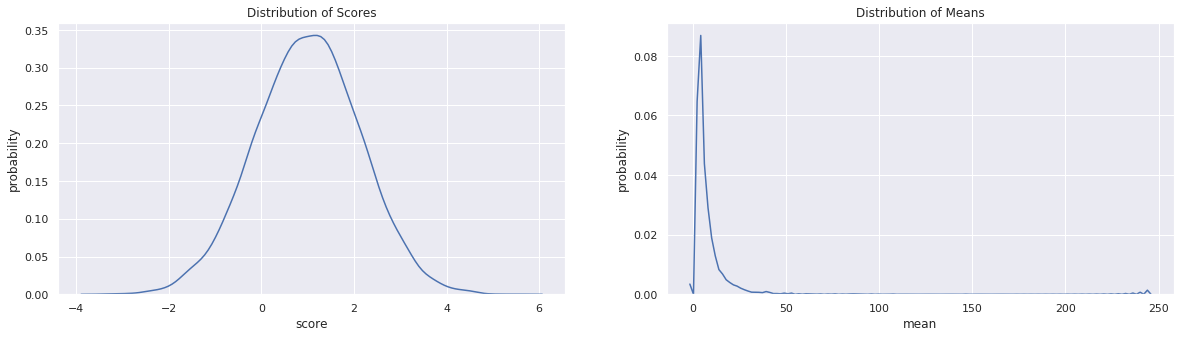

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.kdeplot(z, ax=ax[0])
ax[0].set_title(r'Distribution of Scores')
ax[0].set_xlabel('score')
ax[0].set_ylabel('probability')

sns.kdeplot(y, ax=ax[1])
ax[1].set_title(r'Distribution of Means')
ax[1].set_xlabel('mean')
ax[1].set_ylabel('probability')

## Solve for the Poisson regression model weights

Now we learn the weights of the Poisson regression model using gradient descent. Notice that the loss function of a Poisson regression model is identical to an Ordinary Least Square (OLS) regression model?

$L(\theta) = \frac{1}{n} (\hat{y} - y)^2$

We do not have to worry about writing out the gradient of the loss function since we are using [Autograd](https://github.com/HIPS/autograd).

In [3]:
import autograd.numpy as np
from autograd import grad
from autograd.numpy import exp, log, sqrt

# define the loss function
def loss(w, X, y):
    y_pred = np.exp(np.dot(X, w))
    loss = ((y_pred - y) ** 2.0)
    return loss.mean(axis=None)

#the magic line that gives you the gradient of the loss function
loss_grad = grad(loss)

def learn_weights(X, y, alpha=0.05, max_iter=30000, debug=False):
    w = np.array([0.0 for _ in range(X.shape[1])])
    
    if debug is True:
        print('initial weights = {}'.format(w))

    loss_trace = []
    weight_trace = []

    for i in range(max_iter):
        loss = loss_grad(w, X, y)
        w = w - (loss * alpha)
        if i % 2000 == 0 and debug is True:
            print('{}: loss = {}, weights = {}'.format(i, loss, w))

        loss_trace.append(loss)
        weight_trace.append(w)

    if debug is True:
        print('intercept + weights: {}'.format(w))
    
    loss_trace = np.array(loss_trace)
    weight_trace = np.array(weight_trace)
    
    return w, loss_trace, weight_trace

def plot_traces(w, loss_trace, weight_trace, alpha):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].set_title(r'Log-loss of the weights over iterations, $\alpha=${}'.format(alpha))
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('log-loss')
    ax[0].plot(loss_trace[:, 0], label=r'$\beta$')
    ax[0].plot(loss_trace[:, 1], label=r'$x_0$')
    ax[0].plot(loss_trace[:, 2], label=r'$x_1$')
    ax[0].legend()

    ax[1].set_title(r'Weight learning over iterations, $\alpha=${}'.format(alpha))
    ax[1].set_xlabel('iteration')
    ax[1].set_ylabel('weight')
    ax[1].plot(weight_trace[:, 0], label=r'$\beta={:.2f}$'.format(w[0]))
    ax[1].plot(weight_trace[:, 1], label=r'$x_0={:.2f}$'.format(w[1]))
    ax[1].plot(weight_trace[:, 2], label=r'$x_1={:.2f}$'.format(w[2]))
    ax[1].legend()

We try learning the coefficients with different learning weights $\alpha$. Note the behavior of the traces of the loss and weights for different $\alpha$? The loss function was the same one used for OLS regression, but the loss function for Poisson regression is defined differently. Nevertheless, we still get acceptable results.

### Use gradient descent with $\alpha=0.001$

[1.50066529 0.49134304 0.20836951]


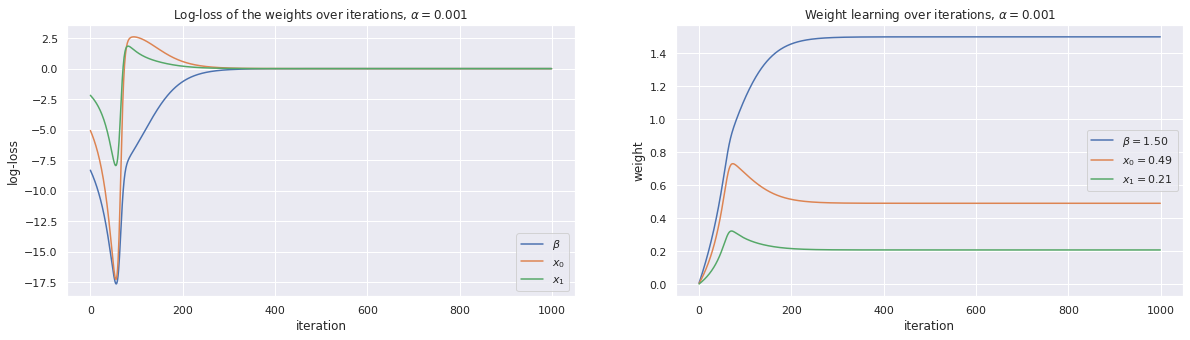

In [4]:
alpha = 0.001
w, loss_trace, weight_trace = learn_weights(X, y, alpha=alpha, max_iter=1000)
plot_traces(w, loss_trace, weight_trace, alpha=alpha)
print(w)

### Use gradient descent with $\alpha=0.005$

[1.50066529 0.49134304 0.20836951]


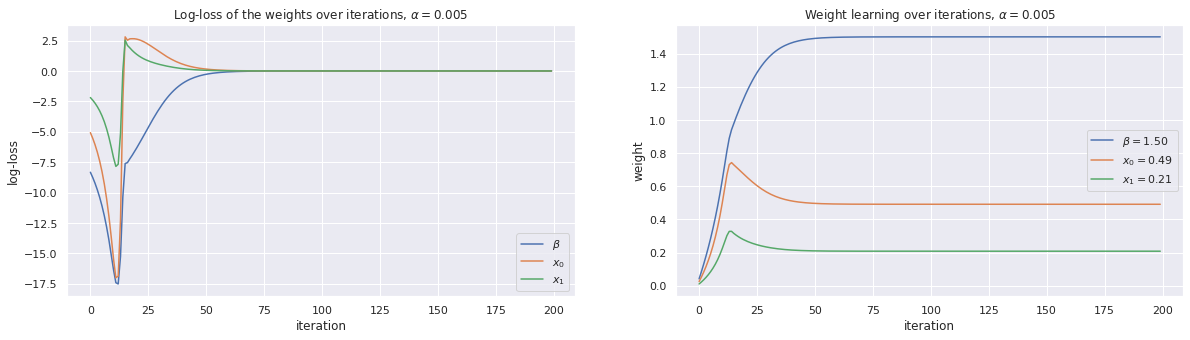

In [5]:
alpha = 0.005
w, loss_trace, weight_trace = learn_weights(X, y, alpha=alpha, max_iter=200)
plot_traces(w, loss_trace, weight_trace, alpha=alpha)
print(w)

### Use gradient descent with $\alpha=0.01$

[1.50393889 0.49616052 0.21077159]


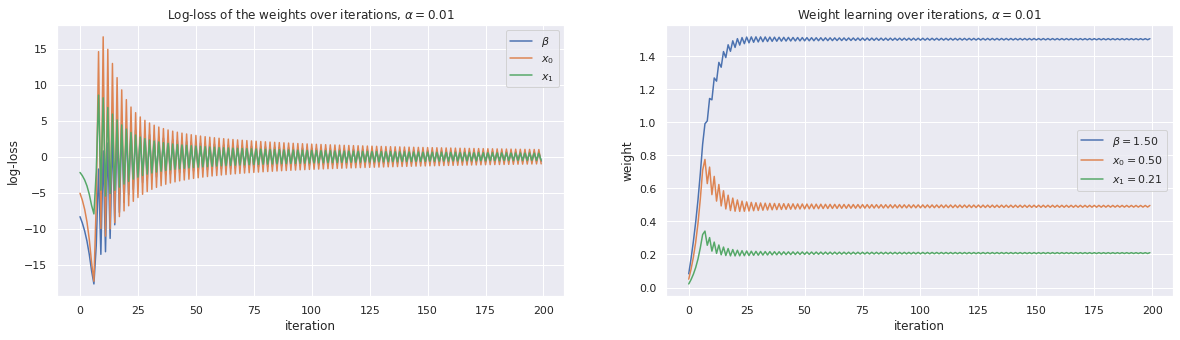

In [6]:
alpha = 0.01
w, loss_trace, weight_trace = learn_weights(X, y, alpha=alpha, max_iter=200)
plot_traces(w, loss_trace, weight_trace, alpha=alpha)
print(w)